### Bidiretional LSTM for Time Series Forecasting

Libs required:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,4)

import numpy as np
import pandas as pd
import plotly
import plotly.graph_objs as go

from keras.preprocessing import sequence
from keras.layers import Dense, LSTM, Bidirectional
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [2]:
plotly.offline.init_notebook_mode(connected=True)

#### Reading the data numerically:

In [3]:
features_train = pd.read_csv('./dataset/X_treino_.csv', index_col=['data'])
et0_train = pd.read_csv('./dataset/y_treino_.csv', index_col=['data'])

features_val = pd.read_csv('./dataset/X_val.csv', index_col=['data'])
et0_val = pd.read_csv('./dataset/y_val.csv', index_col=['data'])

In [4]:
data_train = pd.concat([features_train, et0_train], axis=1)
data_val = pd.concat([features_val, et0_val], axis=1)

In [5]:
BATCH_SIZE = 32
N_INPUT = len(features_train)
N_FEATURES = len(features_train.columns)

In [6]:
data_train.columns

Index(['pressao_atm_max', 'pressao_atm_min', 'chuva_mm', 'temp_ar_max',
       'temp_ar_min', 'umid_relat_max', 'umid_relat_min', 'rad_solar_total',
       'temp_max', 'temp_min', 'temp_ar_media', 'umid_relat_media',
       'vento_veloc', 'rad_solar_media', 'et0'],
      dtype='object')

In [7]:
trace0 = go.Scatter(
    x = data_train.index,
    y = data_train['pressao_atm_max'],
    name = 'Train'
)

trace1 = go.Scatter(
    x = data_val.index,
    y = data_val['pressao_atm_max'],
    name = 'Validation'
)

data = [trace0, trace1]

plotly.offline.iplot(data)

In [8]:
trace0 = go.Scatter(
    x = data_train.index,
    y = data_train['et0'],
    name = 'Train'
)

trace1 = go.Scatter(
    x = data_val.index,
    y = data_val['et0'],
    name = 'Validation'
)

data = [trace0, trace1]

plotly.offline.iplot(data)

#### Preprocess the data to a format a neural network can ingest.

We will use the following parameter values:

- lookback = 5, i.e. our observations will go back 5 days.
- steps = 1, i.e. our observations will be sampled at one data point per day.
- delay = 1, i.e. our targets will be 24 hours in the future.

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1 # max 288
    i = min_index + lookback # i= 0+5 = 5
    while 1:
        if i + batch_size >= max_index:
            i = min_index + lookback 
        rows = np.arange(i, min(i + batch_size, max_index)) 
        i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][-1]
        yield samples, targets

In [10]:
lookback = 5
step = 1
delay = 1
batch_size = 32

train_gen = generator(data_train['et0'],
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=None,
                      step=step, 
                      batch_size=batch_size) #(len(features_train)-1)

val_gen = generator(data_val['et0'],
                    lookback=lookback,
                    delay=delay,
                    min_index=0,
                    max_index=None,
                    step=step,
                    batch_size=batch_size) #(len(features_val)-1)

train_steps =  len(features_train) // batch_size

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps =  len(features_val) // batch_size

In [11]:
def overfitting_plot(history, name):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training mae')
    plt.plot(epochs, val_loss, 'b', label='Validation mae')
    plt.title('Training and validation loss')
    plt.legend(loc='best')
    plt.savefig('loss_'+name+'.png') 

In [12]:
model = Sequential()
model.add(Bidirectional(LSTM(32,
                             dropout=0.2,
                             recurrent_dropout=0.2))) # 50
model.add(Dense(1))

# Stacking more layers
# model.add(Bidirectional(LSTM(32, 
#                              dropout=0.2, 
#                              recurrent_dropout=0.2, 
#                              return_sequences=True))) activation='relu'

#else:
#    model.add(Bidirectional(LSTM(32, activation='relu', input_shape=(N_INPUT, N_FEATURES))))
# input_shape=(None, float_data.shape[-1]

In [13]:
model.compile(optimizer='adam', 
              loss='mean_absolute_error', 
              metrics=['mae', 'mse'])
#testar Adam 1e-3 and 5e-4

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

RuntimeError: You must compile your model before using it.

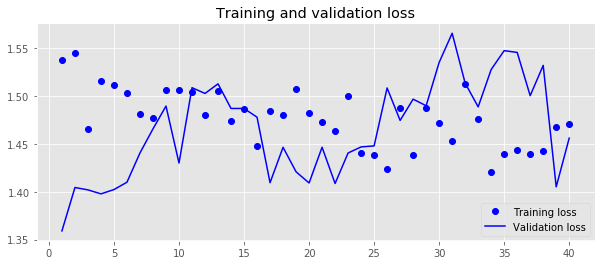

In [120]:
overfitting_plot(history, 'e001')

There are many other things you could try, in order to improve performance on the temperature-forecasting problem:
- Adjust the number of units in each recurrent layer in the stacked setup. The current choices are largely arbitrary and thus probably suboptimal.
- Adjust the learning rate used by the RMSprop optimizer. Change the optimizer to Adam.
- Try using LSTM layers instead of GRU layers (vice-versa).
- Try using a bigger densely connected regressor on top of the recurrent layers: that is, a bigger Dense layer or even a stack of Dense layers.
- Don’t forget to eventually run the best-performing models (in terms of validation MAE ) on the test set! Otherwise, you’ll develop architectures that are overfitting to the validation set.

In [121]:
model.save('./saved_models/e001.h5')

In [122]:
model.evaluate_generator(test_gen,steps=test_steps)

[1.6325380717005049, 1.6325380717005049, 4.1739006723676413]

In [123]:
np.sqrt(4.1739006723676413)

2.0430126461594997

* MAE  = 1.6325380717005049

* RMSE = 2.0430126461594997